In [1]:
import xarray as xr
from dask.dot import dot_graph
import dask.array as da
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import xgcm
from xmitgcm import open_mdsdataset
import xrft

In [2]:
import distributed
print(distributed.__version__)
#import blosc
#print(blosc.__version__)
import dask
print(dask.__version__)
print(xr.__version__)

1.16.3+56.g17144fe
0.14.3
0.9.5-1-gab4ffee


In [3]:
ddir = '/rigel/ocp/users/ra2697/channel_topography/GCM/run_taux2000_rb0110_bump'
%prun ds = open_mdsdataset(ddir, prefix=['U', 'Eta', 'T', 'V', 'S', 'W'])
# 3 minutes

/rigel/home/ra2697/xmitgcm/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


## XArray wraps netCDF Data

In [3]:
ds

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1566)
Coordinates:
    iter                 (time) int64 8294400 8294976 8295552 8296128 ...
  * time                 (time) int64 8294400 8294976 8295552 8296128 ...
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * YG                   (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * XG                   (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
    rAz           

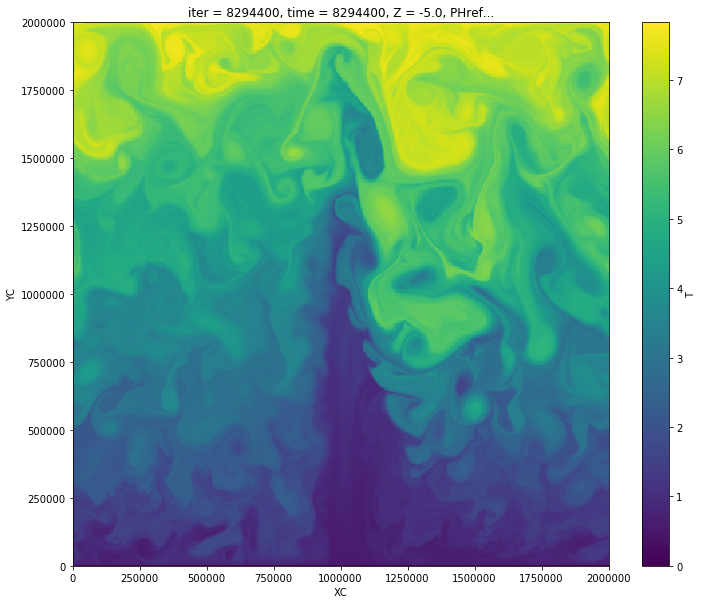

In [35]:
plt.figure(figsize=(12,10))
ds['T'].isel(time=0, Z=0).plot()

## Analysis Task: Power Spectrum

Fourier Transform:
$ v(x, t) \to \hat v(k, t) $

Wavenumber Power Spectrum:
$ \langle v^\ast v \rangle (k) $

In [4]:
from dask.distributed import Client

In [23]:
client.restart()

<Client: scheduler='tcp://10.43.8.220:8786' processes=5 cores=20>

In [19]:
client.shutdown()

In [5]:
#scheduler_file = '../.dask_scheduler/dask_scheduler_file-' + os.environ['SLURM_JOBID']
scheduler_file = '/rigel/home/ra2697/.dask_schedule_file.json'
client = Client(scheduler_file=scheduler_file)
client

Client Scheduler: tcp://10.43.8.35:8786 Dashboard: http://10.43.8.35:8787,Cluster Workers: 5 Cores: 20 Memory: 500.00 GB


In [6]:
# persist dataset, load in to memory
%time dsp = ds.persist()

CPU times: user 4.67 s, sys: 50.1 ms, total: 4.72 s
Wall time: 4.71 s


In [7]:
dsp.nbytes / 1e9

201.532833252

In [8]:
dsp

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1566)
Coordinates:
    iter                 (time) int64 8294400 8294976 8295552 8296128 ...
  * time                 (time) int64 8294400 8294976 8295552 8296128 ...
  * YG                   (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * XG                   (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
    dxC           

In [44]:
# take the mean of the whole dataset
%time dsm = (dsp**2).mean().compute()
dsm

CPU times: user 5.2 s, sys: 66.5 ms, total: 5.27 s
Wall time: 23.7 s


<xarray.Dataset>
Dimensions:  ()
Data variables:
    U        float32 0.0176819
    S        float32 1206.89
    V        float32 0.0211135
    T        float32 6.53258
    W        float32 7.58278e-09
    Eta      float32 0.100053

In [9]:
# rechunk in time 
dspr = dsp.chunk({'time': len(dsp.time),
# crashed
#                  'Z': 1, 'Zl':1, 'Zp1': 1,
                   'YC': 1, 'YG': 1
                 }).persist()
#dspr.chunks

In [10]:
dspr

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 1566)
Coordinates:
    iter                 (time) int64 8294400 8294976 8295552 8296128 ...
  * time                 (time) int64 8294400 8294976 8295552 8296128 ...
  * YG                   (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * XG                   (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 ...
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 ...
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 ...
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 ...
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 ...
    dxC           

In [17]:
# 2D cross spectrum
import dask.array

w_fft = dask.array.fft.fftn(dspr.W.data, axes=(0,3))
w_2d_ps = (w_fft * w_fft.conj()).real.mean(axis=2)
w_2d_psc = w_2d_ps.compute()

In [39]:
v_fft = dask.array.fft.fftn(dspr.V.data, axes=(0,3))
v_2d_ps = (v_fft * v_fft.conj()).real.mean(axis=2)
v_2d_psc = v_2d_ps.compute()

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/dask/array/core.py:476: RuntimeWarning: invalid value encountered in multiply
  o = func(*args, **kwargs)


In [23]:
t_fft = dask.array.fft.fftn(dspr['T'].data, axes=(0,3))
wt_2d_cross_spec = (t_fft * w_fft.conj()).real.mean(axis=2).compute()

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/dask/array/core.py:476: RuntimeWarning: invalid value encountered in multiply
  o = func(*args, **kwargs)


In [41]:
vt_2d_cross_spec = (t_fft * v_fft.conj()).real.mean(axis=2).compute()

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/dask/array/core.py:476: RuntimeWarning: invalid value encountered in multiply
  o = func(*args, **kwargs)


In [44]:
from matplotlib.colors import SymLogNorm

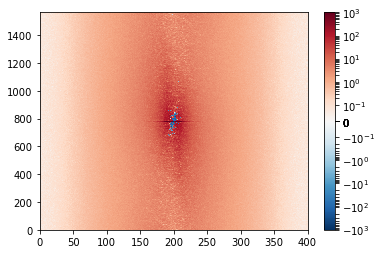

In [59]:
plt.pcolormesh(np.fft.fftshift(wt_2d_cross_spec[:,5], axes=(0,1)), cmap='RdBu_r',
               norm=SymLogNorm(0.1, vmin=-1e3, vmax=1e3))
plt.colorbar()


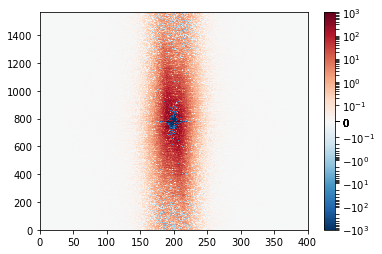

In [60]:
plt.pcolormesh(np.fft.fftshift(wt_2d_cross_spec[:,15], axes=(0,1)), cmap='RdBu_r',
               norm=SymLogNorm(0.1, vmin=-1e3, vmax=1e3))
plt.colorbar()

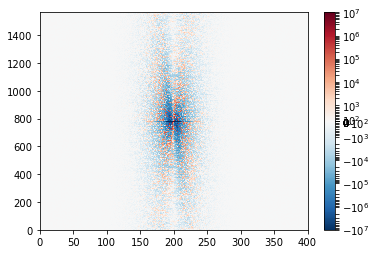

In [64]:
plt.pcolormesh(np.fft.fftshift(vt_2d_cross_spec[:,5], axes=(0,1)), cmap='RdBu_r',
               norm=SymLogNorm(1e3, vmin=-1e7, vmax=1e7))
plt.colorbar()


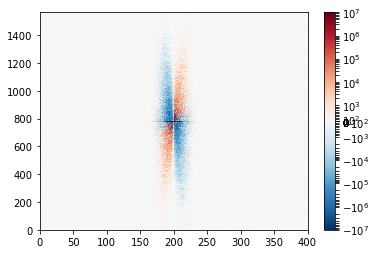

In [63]:
plt.pcolormesh(np.fft.fftshift(vt_2d_cross_spec[:,15], axes=(0,1)), cmap='RdBu_r',
               norm=SymLogNorm(1e3, vmin=-1e7, vmax=1e7))
plt.colorbar()


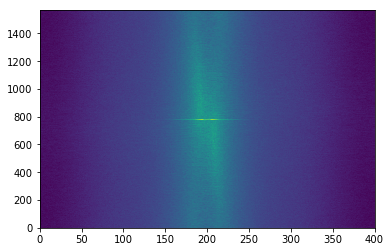

In [27]:
plt.pcolormesh(np.log10(np.fft.fftshift(w_2d_psc[:,10], axes=(0,1))))

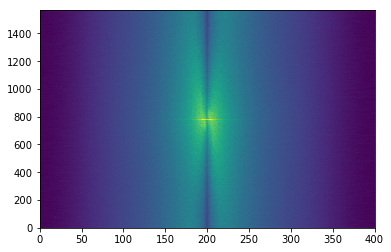

In [40]:
plt.pcolormesh(np.log10(np.fft.fftshift(v_2d_psc[:,10], axes=(0,1))))

In [9]:
# take the Fourier transform along one dimension
v_fft = xrft.dft(ds.V, dim=['XC'], shift=False)
# multiply by complex conjugate
pow_spec = (v_fft*v_fft.conj()).mean(dim=('YG','time'))
pow_spec = pow_spec.astype('f8').rename('V_power_spectrum')
pow_spec

/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: pandas.core.common.is_timedelta64_dtype is deprecated. import from the public API: pandas.api.types.is_timedelta64_dtype instead
  from ipykernel import kernelapp as app


<xarray.DataArray 'V_power_spectrum' (Z: 40, freq_XC: 400)>
dask.array<astype, shape=(40, 400), dtype=float64, chunksize=(40, 400)>
Coordinates:
    freq_XC_spacing  float64 5e-07
  * freq_XC          (freq_XC) float64 0.0 5e-07 1e-06 1.5e-06 2e-06 2.5e-06 ...
  * Z                (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

In [10]:
ds['V'].nbytes / 1e9 # data size in Gigabytes (GB)

40.0896

In [11]:
print(client)
%time pow_spec.load()

<Client: scheduler='tcp://10.43.8.220:8786' processes=5 cores=20>
CPU times: user 4.21 s, sys: 57.9 ms, total: 4.27 s
Wall time: 1min 38s


<xarray.DataArray 'V_power_spectrum' (Z: 40, freq_XC: 400)>
array([[  1.617059e-12,   4.936453e+01,   1.782412e+02, ...,   3.873610e+02,
          1.782412e+02,   4.936453e+01],
       [  1.292125e-12,   4.942939e+01,   1.780007e+02, ...,   3.863439e+02,
          1.780007e+02,   4.942939e+01],
       [  1.058217e-12,   5.095904e+01,   1.793554e+02, ...,   3.869065e+02,
          1.793554e+02,   5.095904e+01],
       ..., 
       [  4.797007e-14,   8.443024e+00,   2.487334e+01, ...,   3.660297e+01,
          2.487334e+01,   8.443024e+00],
       [  4.760242e-14,   8.701984e+00,   2.503824e+01, ...,   3.690131e+01,
          2.503824e+01,   8.701984e+00],
       [  4.953190e-14,   8.772978e+00,   2.426434e+01, ...,   3.609626e+01,
          2.426434e+01,   8.772978e+00]])
Coordinates:
    freq_XC_spacing  float64 5e-07
  * freq_XC          (freq_XC) float64 0.0 5e-07 1e-06 1.5e-06 2e-06 2.5e-06 ...
  * Z                (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 ...

In [10]:
5*60+33

333

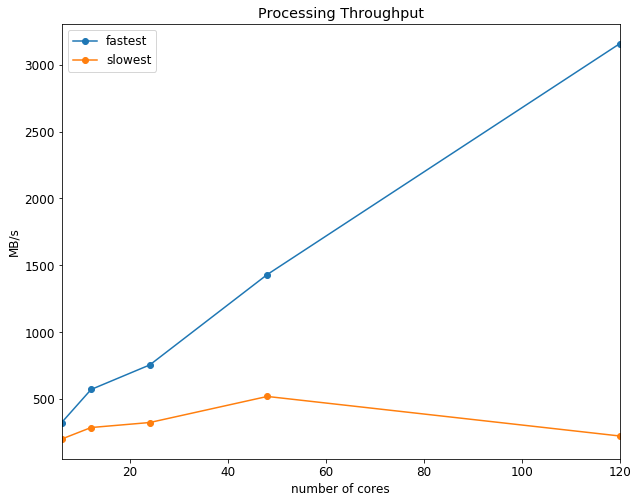

In [137]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(10,8))
# timing data
timing = pd.DataFrame([
    (1,24,123.), # data not cached
    (1,24,53.),
    (1,24,102.),
    (1,24,53.),
    (1,12,139.),
    (1,12,114.),
    (1,12,70.),
    (1,6,198),
    (1,6,123),
    (2,48,77.),
    (2,48,28.),
    (2,48,28.1),
    (5,120,178.),
    (5,120,13.),
    (5,120,12.7),
    (5,120,12.8),
    (5,120,13.5),
    (5,120,61.),
    (5,120,15.5),
    (5,120,54.4),
    # these are from 3/31/2017, something was wrong with the cluster
    (5,120,333)
    ],columns=('nprocs', 'ncores', 'time'))
#  (MB/s)
timing['throughput'] = (ds['V'].nbytes /1e6)/ timing['time']
timing.groupby('ncores')['throughput'].max().plot(marker='o', label='fastest')
timing.groupby('ncores')['throughput'].min().plot(marker='o', label='slowest')
plt.legend(loc='upper left')
plt.title('Processing Throughput')
plt.xlabel('number of cores')
plt.ylabel('MB/s')

In [12]:
import dask.array as da

In [13]:
import xgcm

In [24]:
grid = xgcm.Grid(dsp)
grid

<xgcm.Grid>
X-axis:     XC: 400 (cell center), XG: 400 (cell face, shift -1) periodic
Y-axis:     YC: 400 (cell center), YG: 400 (cell face, shift -1) periodic

In [25]:
vort3 = (-grid.diff(dsp.U*dsp.dxC, 'Y') + grid.diff(dsp.V*dsp.dyC, 'X'))/dsp.rAz
vort3

distributed.utils - ERROR - ('getitem-ac9e295d27b97052a6906fd72028858b', 0, 0)
Traceback (most recent call last):
  File "/rigel/home/ra2697/distributed/distributed/utils.py", line 212, in f
    result[0] = yield make_coro()
  File "/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 1015, in run
    value = future.result()
  File "/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/tornado/concurrent.py", line 237, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 3, in raise_exc_info
  File "/rigel/home/ra2697/miniconda/envs/dask_distributed/lib/python3.5/site-packages/tornado/gen.py", line 285, in wrapper
    yielded = next(result)
  File "/rigel/home/ra2697/distributed/distributed/client.py", line 1540, in _get
    restrictions, loose_restrictions, resources=resources)
  File "/rigel/home/ra2697/distributed/distributed/client.py", line 1515, in _graph_to_futures
    raise CancelledError(v

CancelledError: ('getitem-ac9e295d27b97052a6906fd72028858b', 0, 0)

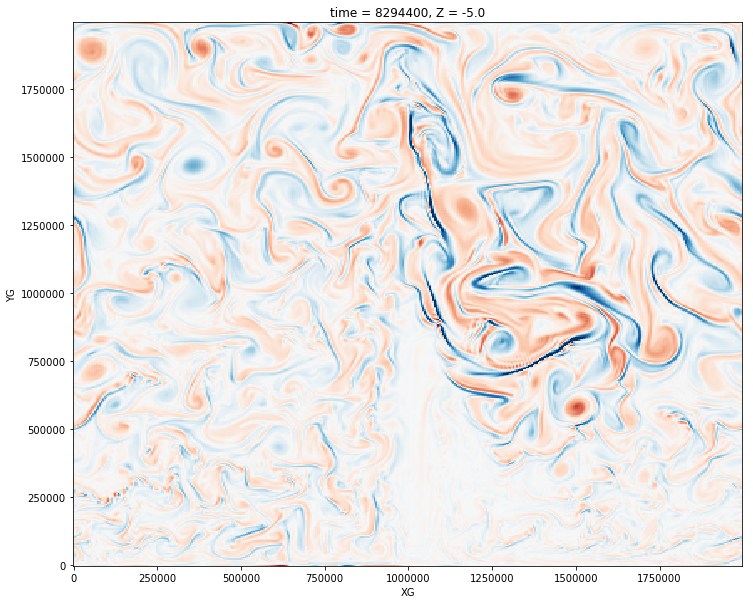

In [58]:
fig, ax = plt.subplots(figsize=(12,10))
vort3[0,0].plot(vmax=1e-4, add_colorbar=False)

In [17]:
vort3_data = vort3.isel(Z=0).data
#vort3_data_flat = vort3_data.reshape((nt, (ny*nx)))
vort3_hist, bins = da.histogram(vort3.isel(Z=0).data, bins=np.arange(-7e-4,7e-4,1e-5))

NameError: name 'vort3' is not defined

In [60]:
%time vort3_hist_, bins_ = da.compute(vort3_hist, bins)

CPU times: user 5.16 s, sys: 215 ms, total: 5.38 s
Wall time: 44.4 s


In [98]:
# it might just be the rolling that causes the histogram to be slow
%time (vort3_data**2).mean().compute()

CPU times: user 4.47 s, sys: 52.6 ms, total: 4.53 s
Wall time: 1min 51s


3.140615e-10

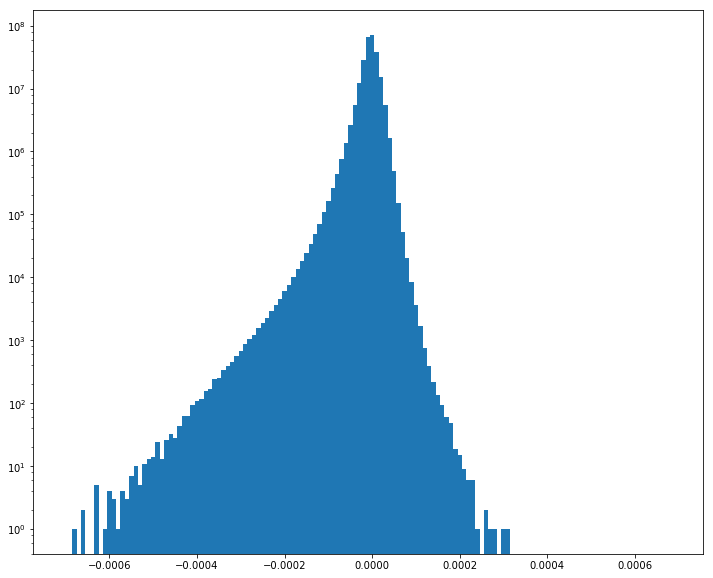

In [61]:
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(bins_[:-1], vort3_hist_, width=bins_[1]-bins[0])
ax.set_yscale('log')

In [106]:
# can dask do it faster?
uvel = ds.U.data
vvel = ds.V.data
# no! dask has no roll
#vort_toy = -(uvel - ) + (vvel - da.roll(vvel, -1))
#%time (vort_toy**2).mean().compute()

In [132]:
# test of rolling speed
delta_u = grid.diff(ds.U, 'Y')
du2_mean = (delta_u.isel(Z=0)**2).mean()
%time du2_mean.compute()

CPU times: user 7.73 s, sys: 742 ms, total: 8.47 s
Wall time: 45.9 s


<xarray.DataArray 'U' ()>
array(0.002671667141839862, dtype=float32)
Coordinates:
    Z        >f4 -5.0

In [95]:
eta_hist, eta_bins = da.histogram(ds.Eta.data, bins=np.arange(-1.,1.,0.1))
eta_hist_, eta_bins_ = da.compute(eta_hist, eta_bins)

<Container object of 19 artists>

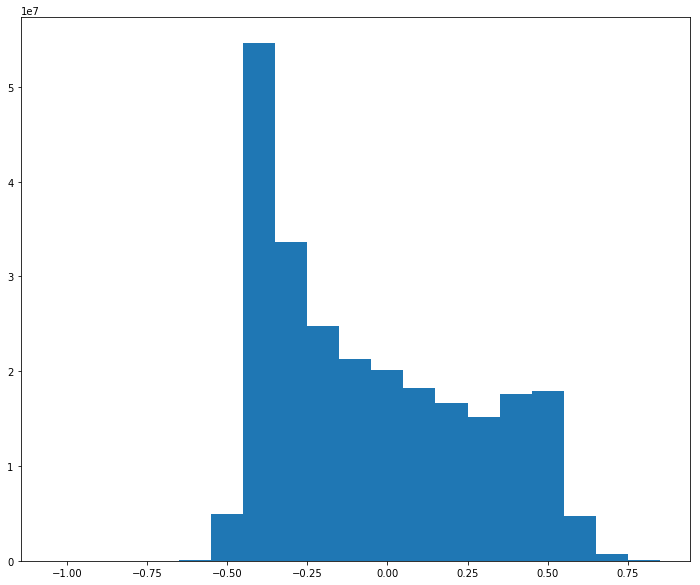

In [97]:
fig, ax = plt.subplots(figsize=(12,10))
ax.bar(eta_bins_[:-1], eta_hist_, width=eta_bins_[1]-eta_bins[0])

In [16]:
# something more computational: SVD
eta_data = ds.Eta.data
nt, ny, nx = eta_data.shape
eta_data_flat = eta_data.reshape((nt, (ny*nx)))
eta_data_flat

dask.array<reshape..., shape=(1566, 160000), dtype=float32, chunksize=(1, 160000)>

In [66]:
u, s, v = da.linalg.svd_compressed(eta_data_flat, 5, n_power_iter=2)
#u, s, v = da.linalg.svd(eta_data_flat)

In [67]:
print(u.shape, s.shape, v.shape)

(1566, 5) (5,) (5, 160000)


In [ ]:
%time u_, s_, v_ = da.compute(u, s, v)

In [70]:
v_rs = v_.reshape((5,ny,nx))

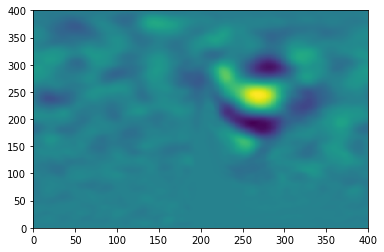

In [74]:
plt.pcolormesh(v_rs[1])

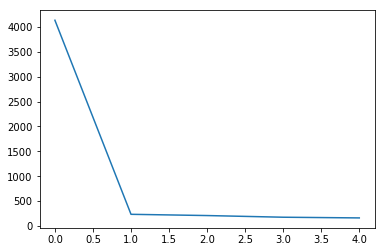

In [77]:
plt.plot(s_)

In [23]:
data = np.random.rand(10000,1000)

In [22]:
%time futures = client.scatter([data])
# with en0: 2.88 s
# with ib0: 1.7s

CPU times: user 528 ms, sys: 664 ms, total: 1.19 s
Wall time: 18 s


In [20]:
%time client.gather(futures)
# with en0: 1.7 s
# with ib0: .5 s

CPU times: user 18.2 ms, sys: 71.2 ms, total: 89.4 ms
Wall time: 311 ms


[array([[ 0.10864542,  0.56264826,  0.72623299, ...,  0.25662114,
          0.66056802,  0.85602567],
        [ 0.44007331,  0.40911858,  0.27592931, ...,  0.01790828,
          0.86896896,  0.40085426],
        [ 0.55643574,  0.23364295,  0.44565527, ...,  0.46645403,
          0.86986497,  0.2716275 ],
        ..., 
        [ 0.70974366,  0.3794911 ,  0.6485889 , ...,  0.61504101,
          0.05642028,  0.27416648],
        [ 0.95199049,  0.61925493,  0.72533518, ...,  0.45537157,
          0.45862503,  0.76435344],
        [ 0.93130109,  0.52656182,  0.59360666, ...,  0.57980583,
          0.33876995,  0.88951232]])]

In [66]:
client.restart()

<Client: scheduler='tcp://10.43.4.211:8786' processes=10 cores=240>